In [1]:
import cv2
import os

def is_folder_empty(folder_path):
    """判断文件夹是否为空"""
    return len(os.listdir(folder_path)) == 0

def video_to_images(video_path, output_folder):
    """将视频切割成多张图片，并按000001.jpg格式命名"""
    
    # 检查输出文件夹是否存在，不存在则创建
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # 检查输出文件夹是否为空
    if not is_folder_empty(output_folder):
        print(f"文件夹 {output_folder} 不为空，跳过视频切割。")
        return
    else:
        print(f"文件夹 {output_folder} 为空，开始视频切割。")
    
    # 打开视频文件
    cap = cv2.VideoCapture(video_path)
    
    frame_number = 1  # 帧计数器
    while cap.isOpened():
        ret, frame = cap.read()  # 读取视频帧
        if not ret:
            break  # 如果没有帧了，退出循环
        
        # 生成图片文件名，按000001.jpg, 000002.jpg格式命名
        image_filename = f"{output_folder}/{frame_number:06d}.jpg"
        
        # 保存图片
        cv2.imwrite(image_filename, frame)
        
        # print(f"Save image: {image_filename}")
        
        frame_number += 1
    
    # 释放视频资源
    cap.release()
    print("Finished.")

# 视频文件路径
video_path = './videos/rubiks_cube.mp4'

# 输出图片的文件夹路径
output_folder = './videos/rubiks_cube'

# 将视频切割成图片并保存
video_to_images(video_path, output_folder)


文件夹 ./videos/rubiks_cube 不为空，跳过视频切割。


In [2]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
from PIL import Image

In [3]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


In [4]:
from sam2.build_sam import build_sam2_video_predictor

# sam2_checkpoint = "../checkpoints/sam2_hiera_tiny.pt"
# model_cfg = "sam2_hiera_t.yaml"
sam2_checkpoint = "../checkpoints/sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

In [5]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

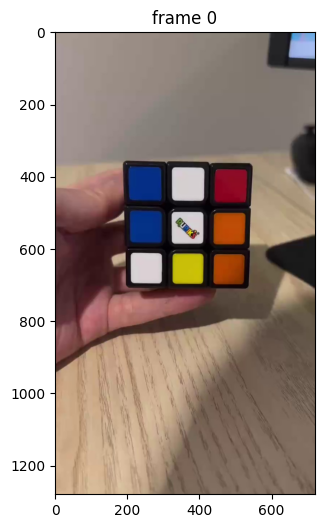

In [6]:
# `video_dir` a directory of JPEG frames with filenames like `<frame_index>.jpg`
video_dir = "./videos/rubiks_cube"

# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

# take a look the first video frame
frame_idx = 0
image = Image.open(os.path.join(video_dir, frame_names[frame_idx]))
plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_idx}")
plt.imshow(image)

In [7]:
width, height = image.size
width, height

(720, 1280)

In [8]:
inference_state = predictor.init_state(video_path=video_dir)

frame loading (JPEG): 100%|███████████████████████████████████████████████████████████| 336/336 [00:07<00:00, 46.49it/s]


In [9]:
predictor.reset_state(inference_state)

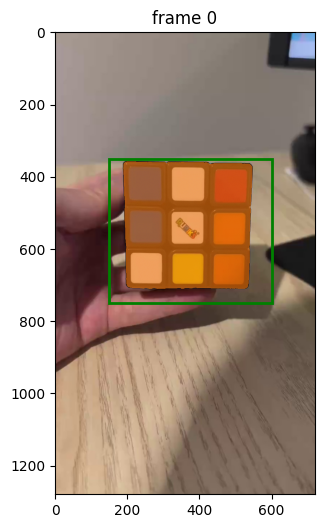

In [10]:
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)

# Let's add a box at (x_min, y_min, x_max, y_max) = (300, 0, 500, 400) to get started
box = np.array([150, 350, 600, 750], dtype=np.float32)

_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    box=box,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_box(box, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

propagate in video: 100%|█████████████████████████████████████████████████████████████| 336/336 [00:19<00:00, 17.42it/s]


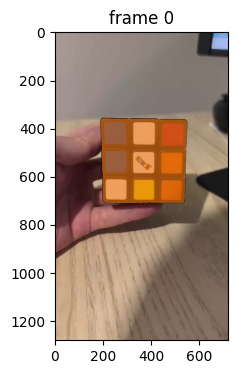

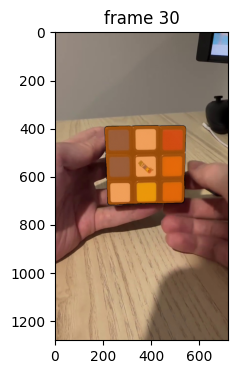

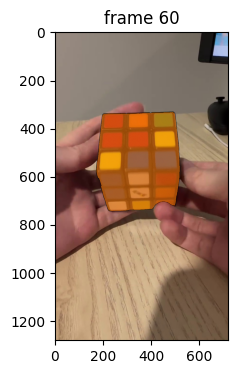

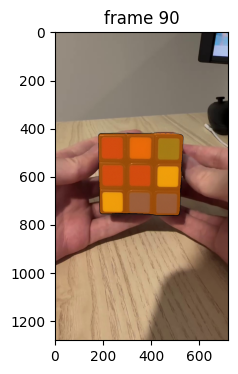

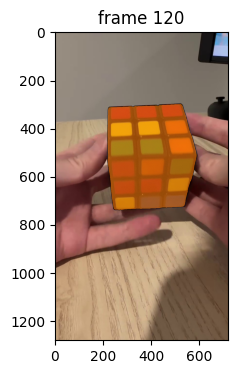

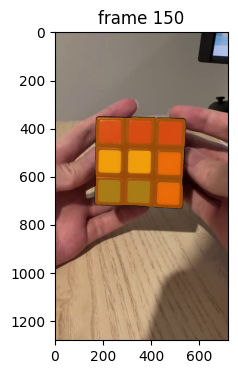

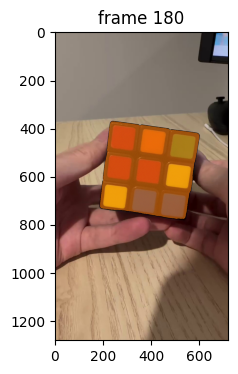

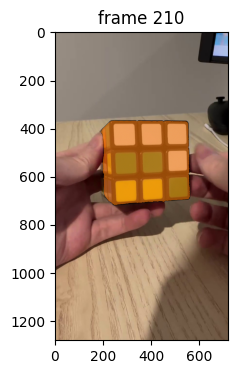

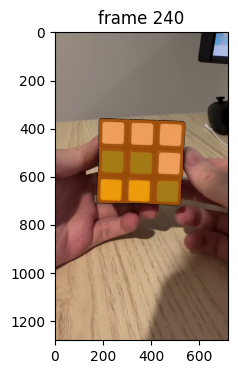

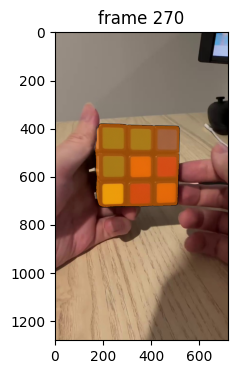

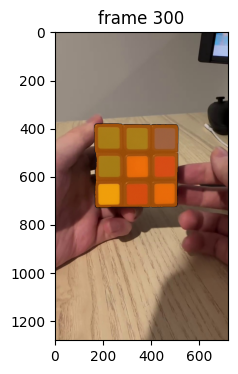

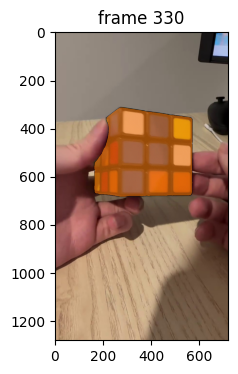

In [11]:
# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

# render the segmentation results every few frames
vis_frame_stride = 30
plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)

In [12]:
# for k, v in video_segments.items():
#     print(k,v)

In [13]:
# print(applied_masks_log)

In [14]:
import cv2
import os
import numpy as np

def extract_cube_face(image, mask):
    """使用掩码提取魔方的一面并分析其颜色块配置"""
    # 将掩码转换为正确的形状和数据类型
    if mask.ndim == 3:
        mask = mask[0]  # 去掉第一维度，变成二维数组
    
    # 确保掩码为uint8类型
    mask = mask.astype(np.uint8)
    
    # 找到掩码的边界框（bounding box）
    true_indices = np.where(mask)
    min_y, max_y = np.min(true_indices[0]), np.max(true_indices[0])
    min_x, max_x = np.min(true_indices[1]), np.max(true_indices[1])
    
    # 计算掩码区域的宽度和高度
    mask_h = max_y - min_y + 1
    mask_w = max_x - min_x + 1

    # 输出调试信息
    # print(f"掩码边界框: X=({min_x}, {max_x}), Y=({min_y}, {max_y}), 宽={mask_w}, 高={mask_h}")
    
    # 根据掩码区域分割为9个色块
    block_size_h = mask_h // 3  # 高度的3等分
    block_size_w = mask_w // 3  # 宽度的3等分

    face_colors = []

    # 确定中心区域比例
    center_factor = 0.4  # 提取色块的中心75%区域

    # 遍历3x3色块区域，分析每个块的主色调
    for row in range(3):
        for col in range(3):
            # 提取每个色块的区域（基于掩码的边界框）
            y1 = min_y + row * block_size_h
            y2 = min_y + (row + 1) * block_size_h
            x1 = min_x + col * block_size_w
            x2 = min_x + (col + 1) * block_size_w
            block = image[y1:y2, x1:x2]  # 提取原图像中对应的色块

            # 进一步提取每个色块的中心75%区域，避免黑边影响
            center_y1 = int((1 - center_factor) / 2 * block_size_h)
            center_y2 = int((1 + center_factor) / 2 * block_size_h)
            center_x1 = int((1 - center_factor) / 2 * block_size_w)
            center_x2 = int((1 + center_factor) / 2 * block_size_w)

            center_block = block[center_y1:center_y2, center_x1:center_x2]

            # 输出调试信息，显示中心区域的大小
            # print(f"行 {row}, 列 {col} 的中心区域大小: 高={center_y2-center_y1}, 宽={center_x2-center_x1}")
            
            # 计算色块的主色调（简单方法：计算RGB均值）
            avg_color = np.mean(center_block, axis=(0, 1))  # 计算每个色块的均值RGB值
            # print(f"行 {row}, 列 {col} 的平均RGB颜色值: {avg_color}")

            face_colors.append(avg_color)

    return face_colors

def classify_color(rgb_color):
    """将RGB颜色分类为魔方的颜色"""
    r, g, b = rgb_color
    # print(f"分类颜色: R={r}, G={g}, B={b}")
    # 基于简单的颜色分类逻辑来区分魔方的主要颜色
    if 90 <= r <= 170 and 0 <= g <= 50 and 0 <= b <= 60:
        return "r"  # 红色
    elif 0 <= r <= 100 and 70 <= g <= 255 and 0 <= b <= 100:
        return "g"  # 绿色
    elif 0 <= r <= 100 and 0 <= g <= 100 and 80 <= b <= 255:
        return "b"  # 蓝色
    elif 120 <= r <= 255 and 120 <= g <= 255 and 0 <= b <= 80:
        return "y"  # 黄色
    elif 120 <= r <= 255 and 125 <= g <= 255 and 140 <= b <= 255:
        return "w"  # 白色
    elif 100 <= r <= 255 and 50 <= g <= 200 and 0 <= b <= 100:
        return "o"  # 橙色
    else:
        return "?"  # 未知颜色或灰色区域

def get_cube_configuration(image, mask):
    """获取魔方当前面的颜色配置"""
    face_colors = extract_cube_face(image, mask)  # 提取每个色块的颜色
    cube_face_config = ''.join([classify_color(color) for color in face_colors])
    # print(f"魔方配置: {cube_face_config}")
    return cube_face_config


def is_square(mask, frame_index, obj_id):
    """判断mask是否接近正方形"""
    if mask.ndim == 3:
        mask = mask[0]  # 去掉第一个维度，变成二维数组

    true_indices = np.where(mask)
    
    if len(true_indices[0]) == 0 or len(true_indices[1]) == 0:
        return False
    
    min_y, max_y = np.min(true_indices[0]), np.max(true_indices[0])
    min_x, max_x = np.min(true_indices[1]), np.max(true_indices[1])
    
    w = max_x - min_x + 1
    h = max_y - min_y + 1

    if h == 0 or w == 0:
        return False
    
    aspect_ratio = w / h
    is_square_flag = 0.98 <= aspect_ratio <= 1.02
    
    return is_square_flag

def calculate_frame_difference(frame1, frame2, threshold_ratio=2.6):
    """计算两帧之间的差异，并返回是否有显著变化（按比例）"""
    diff = cv2.absdiff(frame1, frame2)
    non_zero_count = np.count_nonzero(diff)
    
    total_pixels = frame1.shape[0] * frame1.shape[1]
    difference_ratio = non_zero_count / total_pixels
    # print(f"两帧的差异比例: {difference_ratio:.4f} (阈值: {threshold_ratio})")
    
    return difference_ratio > threshold_ratio

def process_video_segments(video_segments, frame_names, video_dir, step=5):
    """处理每一帧，判断是否为新面，并读取魔方配置"""
    previous_frame = None  # 用于存储前一帧
    cube_configurations = set()
    for frame_index in range(0, len(frame_names), step):
        frame_name = frame_names[frame_index]
        
        # 读取对应帧图像
        # frame_image = cv2.imread(os.path.join(video_dir, frame_name))
        frame_image = Image.open(os.path.join(video_dir, frame_name))
        frame_image = np.array(frame_image.convert("RGB"))
        
        
        # 如果前一帧存在，判断与前一帧的差异，减少重复处理
        if previous_frame is not None:
            if not calculate_frame_difference(previous_frame, frame_image):
                # print(f"帧 {frame_index} 与前一帧相似，跳过处理。")
                continue

        # 处理当前帧的mask
        if frame_index in video_segments:
            segments = video_segments[frame_index]
            for obj_id, mask in segments.items():
                if is_square(mask, frame_index, obj_id):
                    # print(f"帧 {frame_index}, 对象ID {obj_id} 被认为是正方形，应用掩码。")
                    # plt.figure(figsize=(20, 20))
                    # plt.imshow(frame_image)
                    # plt.axis('off')
                    # plt.show()
                    # 从掩码覆盖的区域提取魔方配置
                    cube_configuration = get_cube_configuration(frame_image, mask)
                    # print(f"魔方这一面的配置为: {cube_configuration}")
                    cube_configurations.add(cube_configuration)
                # else:
                #     print(f"帧 {frame_index}, 对象ID {obj_id} 不是正方形，跳过。")

        # 更新前一帧
        previous_frame = frame_image
    return cube_configurations

# 示例调用，假设你的 `video_segments` 已经存在
cube_configuration = process_video_segments(video_segments, frame_names, video_dir, step=5)


In [15]:
cube_configuration

{'bwrbwowyo', 'ggbgoryro', 'rogrryybb', 'rrryyoggo', 'wbybbwboo', 'wwwggwyyg'}

In [16]:
color_order = ['y', 'g', 'r', 'w', 'b', 'o']

# 提取每个面的中心色块（第5个字符），并将其与整个面的配置打包
config_with_centers = [(face[4], face) for face in cube_configuration]

# 按中心色块的顺序进行排序
sorted_config = sorted(config_with_centers, key=lambda x: color_order.index(x[0]))

# 提取排序后的面配置
sorted_faces = [face for _, face in sorted_config]

# 将排序后的面拼接成最终的字符串
config_str = ''.join(sorted_faces)

# 输出最终的结果
print(f"排序后的拼接字符串为: {config_str}")

排序后的拼接字符串为: rrryyoggowwwggwyygrogrryybbbwrbwowyowbybbwbooggbgoryro


In [17]:
center_color_map = {
        'w': 'D',  
        'r': 'F',  
        'g': 'R',  
        'y': 'U',  
        'o': 'B',  
        'b': 'L'   
    }

In [18]:
new_config_str = ""
for c in config_str:
    if c in center_color_map:
        new_config_str += center_color_map[c]
print(f"转换后的魔方状态为: {new_config_str}")

转换后的魔方状态为: FFFUUBRRBDDDRRDUURFBRFFUULLLDFLDBDUBDLULLDLBBRRLRBFUFB


In [19]:
import kociemba

kociemba.solve(new_config_str)

"B' R D F B' R2 D2 B2 U2 D2 L2 U2 F2 R2"